![Logo](images/logo_mds.png)

# Clusterización

La clusterización es una técncia de aprendizaje no supervisado que, partiendo de un conjunto de datos y de un número de clústers solicitado, agrega las observaciones de forma que maximice el parecido entre los objetos de un mismo clúster.

Al tratarse de un aprendizaje no supervisado el objetivo principal es **descubrir información que no sabíamos que está ahí**.

En esta sesión trabajaremos desde los sistemas de **scoring**, **clusterización**, **distancias** y cómo las **funciones de error** pueden ayudarnos a dar el salto entre la analítica **predictiva** y la **prescriptiva**.

# Scoring  / sistemas de segmentación

Antes de empezar con la clusterización propiamente dicha, podemos fijarnos en la forma de realizar el equivalente al clustering manualmente.

Se trata de los sistemas de Scoring.

Un sistema de scoring trata de realizar una segmentación de elementos basándose en reglas pensadas de forma aséptica, es decir, se planifica una regla tratando de minimizar la influencia de los datos en nuestro proceso de razonamiento.

Durante el curso hemos visto dos ejemplos de sistemas de este tipo de clasificación:

1. **ABC**
2. **RFM**

La principal diferencia entre estos sistemas de clasificación y los estudiados en la sesión anterior está en que en estos sistemas (ABC, RFM), se basan en unas reglas planificadas de antemano, mientras que un algoritmo de clasificación, lo que hace es extraer reglas que están "latentes" en los datos.

Tanto **ABC** como **RFM** podrían ser considerados como sistemas de **scoring**.

Un sistema de puntuación asigna valores numéricos a diferentes características de un elemento para obtener una medida resumen de cómo de bueno o malo es respecto a nuestros criterios.

En los sistemas de scoring es habitual utilizar medidas estadísticas discretas como pueden ser los cuartiles, media o mediana para categorizar. Además de estas clasificaciones discretas también podemos utilizar medidas continuas para conseguir una transición más suave en un sistema de scoring.

## Ejemplo de Scoring

Vamos a plantear un modelo de scoring partiendo de un juego de datos de comercio electrónico.

Este juego de datos contiene la siguiente información:

| Campo | Descripción |
|:--:| :--:|
| InvoiceNo | Número de factura | 
| StockCode | Código de producto |
| Description | Descriptivo del producto |
| Quantity | Cantidad vendida |
| InvoiceDate | Fecha de factura |
| UnitPrice | Precio Unitario |
| CustomerID | Id de Cliente  |
| Country | País de procedencia |
| Total | Total de la línea (cantidad * precio unitario) |
| Cantidad_venta | Cantidad venta (sin devoluciones) |
| Cantidad_devo | Cantidad devuelta (sin ventas positivas) |

Los datos abarcan un periodo ligeramente superior a un año (29/11/2016 al 7/12/2017), pero, por no entrar en aspectos técnicos consideraremos que es tiempo suficiente como para sacar conclusiones sobre todos los clientes (normalmente consideraríamos solo los clientes que tengan, al menos, una antigüedad de x meses).

Nos interesa crear un sistema de scoring que contemple varios aspectos:
1. Compran más de lo normal en € (gasto total más alto de lo habitual)
4. Compran más de lo normal en uds
2. Compran con más frecuencia de lo normal (número de tickets)
3. Devuelven menos de lo normal


Vamos a realizar este proceso desde dos puntos de vista diferentes:

- Scoring discreto por quintiles (estilo RFM)
- Scoring continuo 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import PowerTransformer

plt.rcParams['figure.figsize'] = (10,8)


def obtener_df():
    '''
    Lee el CSV utilizado para realizar el scoring
    '''
    df = pd.read_csv('./Datos/Ecommerce.csv').drop(columns=['Unnamed: 8'])

    # Eliminamos las filas que tienen nulos    
    df = df.dropna()
    
    # Convierte la columna de fecha a tipo de datos fecha
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    # y la de cliente a entero (la detecta como float)
    df['CustomerID'] = df.CustomerID.astype(int)
    
    # Calculamos el total de la fila
    df['Total'] = df['Quantity'] * df['UnitPrice']
    
    # Establecemos una columna de cantidad de devolución 
    df['Cantidad_devo'] = df['Quantity']
    df.loc[df['Cantidad_devo'] > 0, 'Cantidad_devo'] = 0
    df['Cantidad_devo'] = df['Cantidad_devo'] * -1

    # Establecemos una columna de cantidad de venta
    df['Cantidad_venta'] = df['Quantity']
    df.loc[df['Cantidad_venta'] < 0, 'Cantidad_venta'] = 0
    
    
    return df

def agregar(df, caracteristica, nivel = 'CustomerID', fn='sum', resultado='-1'):
    '''
    Agrega un dataframe al nivel indicado en nivel, por la característica proporcionada.
    
    La función de agregación a aplicar será la suma por defecto, pudiendo indicar otra.
    
    El parámetro resultado establece el nombre que tendrá la columna de resultado, si no se indica
    nada se establece igual que la función de agregación.
    '''
    if resultado == '-1':
        resultado = fn
    gb = df.groupby(by=nivel)[caracteristica].agg([fn])
    gb = gb.rename({fn: resultado}, axis=1)
    return gb.reset_index()

df = obtener_df()
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Cantidad_devo,Cantidad_venta
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,0,6
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,0,6
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,0,8


### Cómo funciona la función agregar

La función agregar automatiza algunos pásos básicos de la agregación de datos.

Agrega la cantidad de venta (Cantidad_venta) por cliente (CustomerID)

In [2]:
gr = agregar(df,'Cantidad_venta','CustomerID')
gr.sort_values(by='sum',ascending=False).head()

,CustomerID,sum
1703,14646,197491
3033,16446,80997
1895,14911,80515
55,12415,77670
0,12346,74215


Agrega la cantidad de venta (Cantidad_venta) por código de producto:

In [3]:
gr2 = agregar(df,'Cantidad_venta','StockCode')
gr2.sort_values(by='sum',ascending=False).head()

,StockCode,sum
2403,23843,80995
2001,23166,77916
2812,84077,54415
1092,22197,49183
3235,85099B,46181


## Transformación de datos

Debemos normalizar los datos y eliminar outliers

<AxesSubplot:xlabel='venta_total', ylabel='Count'>

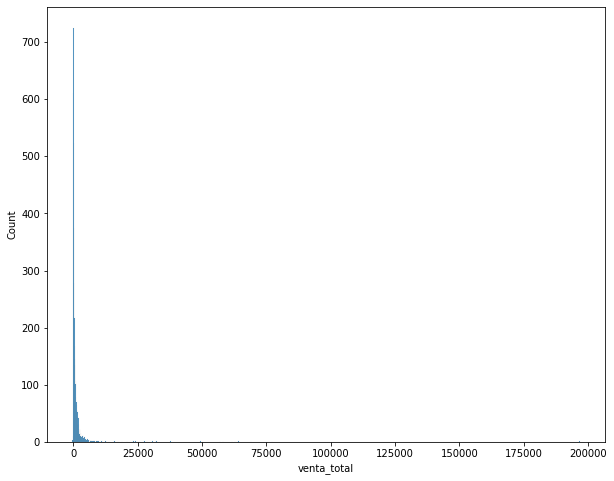

In [4]:
plt.figure()
sns.histplot(agregar(df, 'Quantity', resultado='venta_total')['venta_total'] )

<AxesSubplot:xlabel='vta_transf', ylabel='Count'>

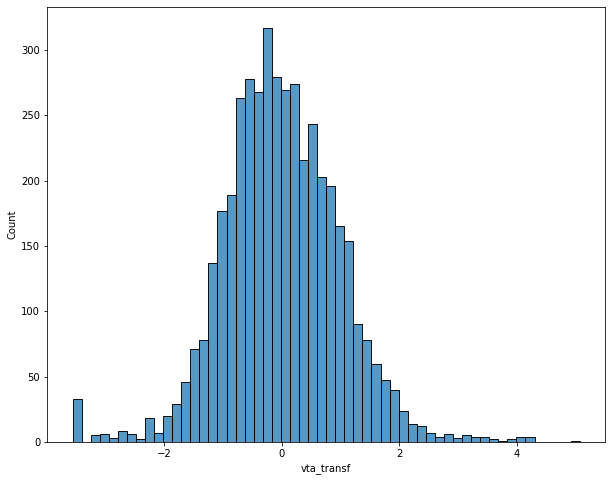

In [5]:
ag_venta = agregar(df, 'Cantidad_venta', resultado='venta_total')

# Puesto que se trata de una distribución exponencial, podemos aplicar una transformación 
# de yeo-johnson a esta serie de datos para normalizarla
ag_venta['vta_transf'] = 0
p = PowerTransformer(method='yeo-johnson')
transformada = p.fit_transform(ag_venta[['venta_total']] )
ag_venta['vta_transf'] = transformada

plt.figure()
sns.histplot(ag_venta['vta_transf'])

In [6]:
outliers_venta = ag_venta[(ag_venta['vta_transf'] > 2) | (ag_venta['vta_transf']< -2)].CustomerID

In [7]:
df.shape

(406829, 11)

In [8]:

# Me quedo con los clientes cuyo códiog de cliente no esté en los outliers de venta
df = df[~df['CustomerID'].isin(outliers_venta)]
df.shape

(342819, 11)

<AxesSubplot:xlabel='sum', ylabel='Count'>

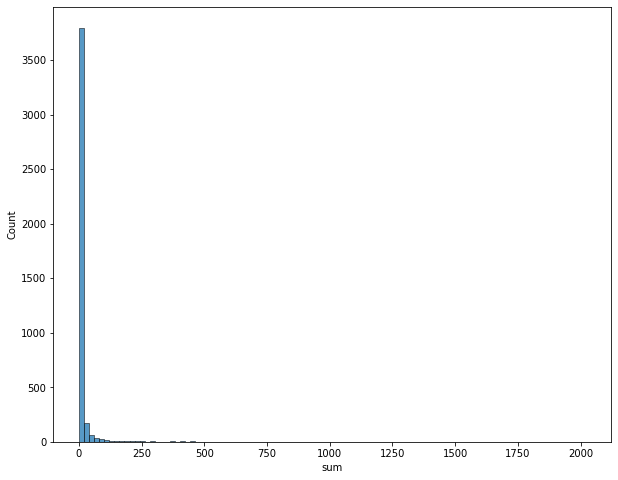

In [9]:
plt.figure()
ag_devo = agregar(df, 'Cantidad_devo')
sns.histplot(data=ag_devo['sum'], bins=100)


El motivo por el que el gráfico se "ve" tan mal es el siguiente, hay muy pocos valores de retorno y muy dispersos.

In [10]:
ag_devo.sort_values(by='sum', ascending=False)

,CustomerID,sum
2226,15482,2022
3255,16938,1515
4079,18133,1350
1553,14533,1242
203,12607,1228
...,...,...
1739,14804,0
1740,14805,0
1741,14806,0
1743,14810,0


<AxesSubplot:xlabel='devo_transf', ylabel='Count'>

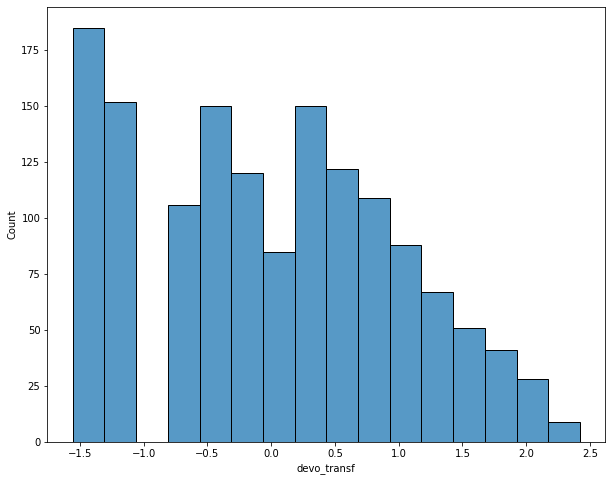

In [11]:
p = PowerTransformer(method='yeo-johnson')

ag_devo = ag_devo.loc[ag_devo['sum'] > 0]

ag_devo['devo_transf'] = p.fit_transform(ag_devo[['sum']])
plt.figure()
sns.histplot(ag_devo['devo_transf'])

No hacemos ninguna eliminación de outliers de la devo puesto que no hay datos suficientes como para considerar que podemos tomar una decisión correcta.

<AxesSubplot:xlabel='count', ylabel='Count'>

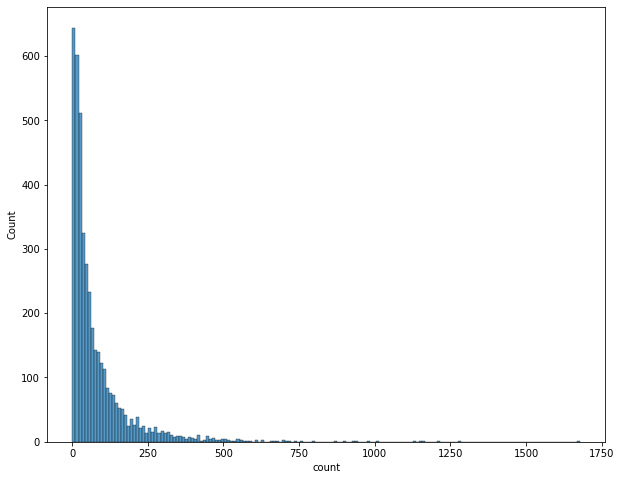

In [12]:
ag_docs = agregar(df, 'InvoiceNo', fn='count')
plt.figure()
sns.histplot(ag_docs['count'])

<AxesSubplot:xlabel='conteo_transf', ylabel='Count'>

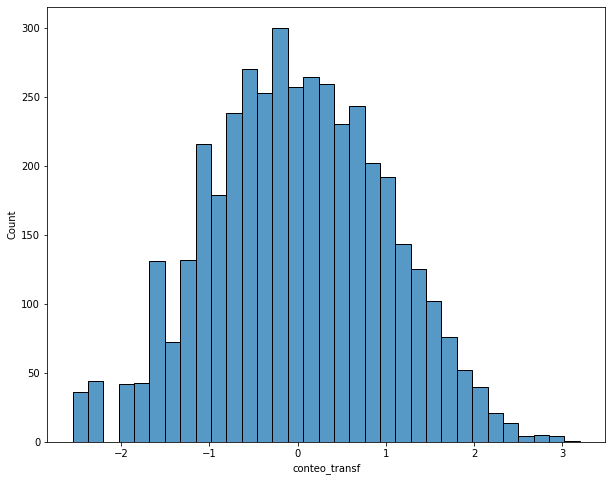

In [13]:
ag_docs['conteo_transf'] = p.fit_transform(ag_docs[['count']])
plt.figure()
sns.histplot(ag_docs['conteo_transf'])

In [14]:
outliers_conteo = ag_docs[(ag_docs['conteo_transf'] > 2) | (ag_docs['conteo_transf']< -2)].CustomerID
df.shape

(342819, 11)

In [15]:
df = df[~df['CustomerID'].isin(outliers_conteo)]
df.shape

(288422, 11)

In [16]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Cantidad_devo,Cantidad_venta
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,0,6
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,0,6
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,0,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34,0,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34,0,6
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2017-12-07,0.85,12680,France,10.20,0,12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2017-12-07,2.10,12680,France,12.60,0,6
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2017-12-07,4.15,12680,France,16.60,0,4
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2017-12-07,4.15,12680,France,16.60,0,4


<AxesSubplot:xlabel='sum', ylabel='Count'>

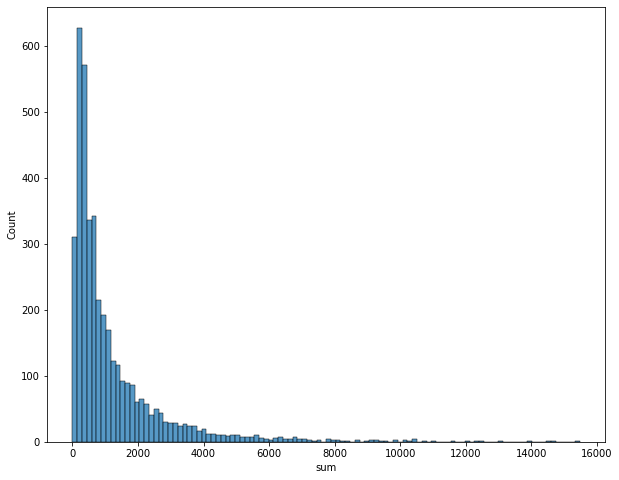

In [17]:
ag_imp = agregar(df, 'Total')

ag_imp = ag_imp.loc[ag_imp['sum'] > 0]
plt.figure()
sns.histplot(ag_imp['sum'])

<AxesSubplot:xlabel='Total_transf', ylabel='Count'>

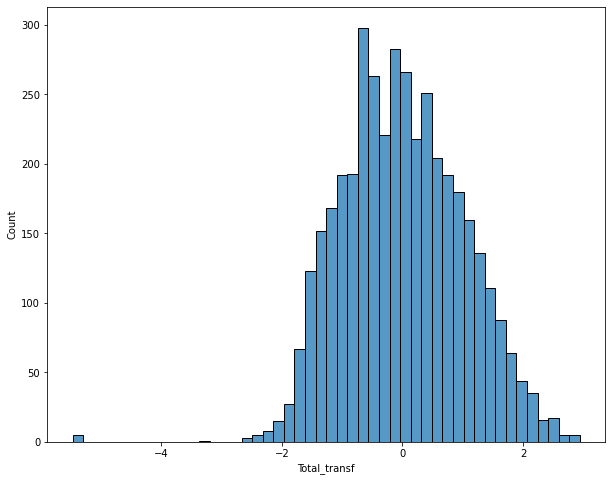

In [18]:
ag_imp['Total_transf'] = p.fit_transform(ag_imp[['sum']])

plt.figure()
sns.histplot(ag_imp['Total_transf'])

In [19]:
outliers_imp = ag_imp[(ag_imp['Total_transf'] > 2) | (ag_imp['Total_transf']< -2)].CustomerID
df.shape

(288422, 11)

In [20]:
df = df[~df['CustomerID'].isin(outliers_imp)]
df.shape

(267092, 11)

In [21]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Cantidad_devo,Cantidad_venta
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,0,6
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,0,6
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,0,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34,0,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34,0,6
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2017-12-07,0.85,12680,France,10.20,0,12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2017-12-07,2.10,12680,France,12.60,0,6
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2017-12-07,4.15,12680,France,16.60,0,4
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2017-12-07,4.15,12680,France,16.60,0,4


In [22]:
df = df.groupby(by='CustomerID').agg({'InvoiceNo': 'count', 'Cantidad_devo': 'sum', 'Cantidad_venta': 'sum', 'Total': 'sum'}).reset_index()

In [23]:
columnas_datos = ['Numero_tickes', 'Uds_devo', 'Uds_venta', 'Eur_venta']

df.columns =  ['Cliente', 'Numero_tickes', 'Uds_devo', 'Uds_venta', 'Eur_venta']

for x in ['Numero_tickes', 'Uds_devo', 'Uds_venta', 'Eur_venta']:
    df[x+'_norm'] = p.fit_transform(df[[x]])
    
df

,Cliente,Numero_tickes,Uds_devo,Uds_venta,Eur_venta,Numero_tickes_norm,Uds_devo_norm,Uds_venta_norm,Eur_venta_norm
0,12347,182,0,2458,4310.00,1.425992,-0.688685,1.772114,2.708493
1,12348,31,0,2341,1797.24,-0.268441,-0.688685,1.724764,0.760126
2,12349,73,0,631,1757.55,0.541335,-0.688685,0.481880,0.726135
3,12350,17,0,197,334.40,-0.819070,-0.688685,-0.573395,-0.656387
4,12352,95,66,536,1545.41,0.794572,1.796968,0.331211,0.541785
...,...,...,...,...,...,...,...,...,...
3896,18278,9,0,66,173.90,-1.377307,-0.688685,-1.521172,-0.858587
3897,18280,10,0,45,180.60,-1.287080,-0.688685,-1.841896,-0.849565
3898,18281,7,0,54,80.82,-1.588106,-0.688685,-1.690014,-0.993005
3899,18282,13,5,103,176.60,-1.058278,1.400020,-1.140848,-0.854943


### Asignación de quintiles

Vamos a obtener quintiles

Para el scoring discreto "clásico" de quitiles no usamos los valores normalizados sino los absolutos. En el scoring continuo sí necesitaremos los valores absolutos.

In [24]:
def asigna_quintil(df, variable):
    print(f'asignando {variable}')
    quintiles = df[variable].quantile([0, .2, .4, .6, .8])
    
    df[variable + '_quintil'] = 0
    
    for i,x in enumerate(quintiles):
        print(i+1,x)
        df.loc[df[variable] >= x, variable+ '_quintil'] = i+1

In [25]:
for x in columnas_datos:
    asigna_quintil(df, x)

asignando Numero_tickes
1 3.0
2 15.0
3 30.0
4 56.0
5 109.0
asignando Uds_devo
1 0.0
2 0.0
3 0.0
4 0.0
5 5.0
asignando Uds_venta
1 17.0
2 138.0
3 268.0
4 498.0
5 1016.0
asignando Eur_venta
1 -1165.3
2 253.04
3 463.95
4 847.61
5 1677.48


In [26]:
df

,Cliente,Numero_tickes,Uds_devo,Uds_venta,Eur_venta,Numero_tickes_norm,Uds_devo_norm,Uds_venta_norm,Eur_venta_norm,Numero_tickes_quintil,Uds_devo_quintil,Uds_venta_quintil,Eur_venta_quintil
0,12347,182,0,2458,4310.00,1.425992,-0.688685,1.772114,2.708493,5,4,5,5
1,12348,31,0,2341,1797.24,-0.268441,-0.688685,1.724764,0.760126,3,4,5,5
2,12349,73,0,631,1757.55,0.541335,-0.688685,0.481880,0.726135,4,4,4,5
3,12350,17,0,197,334.40,-0.819070,-0.688685,-0.573395,-0.656387,2,4,2,2
4,12352,95,66,536,1545.41,0.794572,1.796968,0.331211,0.541785,4,5,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3896,18278,9,0,66,173.90,-1.377307,-0.688685,-1.521172,-0.858587,1,4,1,1
3897,18280,10,0,45,180.60,-1.287080,-0.688685,-1.841896,-0.849565,1,4,1,1
3898,18281,7,0,54,80.82,-1.588106,-0.688685,-1.690014,-0.993005,1,4,1,1
3899,18282,13,5,103,176.60,-1.058278,1.400020,-1.140848,-0.854943,1,5,1,1


### Asignación de Puntuación - Estrategias

Una vez tenemos los quintiles preparados podemos aplicar diferentes estrategias para clasificar nuestros datos:

1. Concatenación (como en el modelo RFM)
1. Adición
1. Multiplicación

#### Concatenación

Simplemente concatenamos los valores.

> + Mantenemos la información de cómo se generó la medida

> - Es muy difícil comparar puntuaciones (¿mejor un 5321 o un 4411?)
> - Con 4 variables y quintiles tenemos 5^4 posibilidades (625 bloques)


#### Adición

> + Compone los datos facilitando la comparación

> - Exige pensar detenidamente cuánto peso asignar a cada medida (¿es lo mismo un 5 en devoluciones que en cantidad de tickets?)

#### Multiplicación

Multiplicamos los valores

> + Exagera los valores positivos y negativos (los malos se vuelven muy malos, los buenos muy buenos)

> - Dejan grandes huecos sin datos, por ejemplo entre los 5·5·5·5 = 625 y los 5·5·5·4 = 500 hay 125 posiciones vacantes.



In [27]:
df['concat'] = df.apply(lambda x: str(x.Uds_venta_quintil) + str(x.Numero_tickes_quintil) + str(x.Uds_devo_quintil) + str(x.Eur_venta_quintil), axis=1)
df['aditivo'] = df.apply(lambda x: x.Uds_venta_quintil + x.Numero_tickes_quintil + x.Uds_devo_quintil + x.Eur_venta_quintil, axis=1)
df['multiplicativo'] = df.apply(lambda x: x.Uds_venta_quintil * x.Numero_tickes_quintil * x.Uds_devo_quintil * x.Eur_venta_quintil, axis=1)




<AxesSubplot:xlabel='concat', ylabel='Count'>

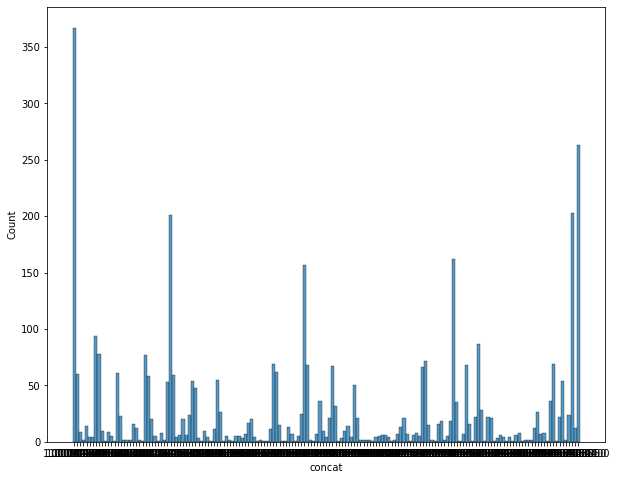

In [28]:
plt.figure()
sns.histplot(df['concat'].sort_values(),  bins=len(df['concat'].unique()))

<AxesSubplot:xlabel='aditivo', ylabel='Count'>

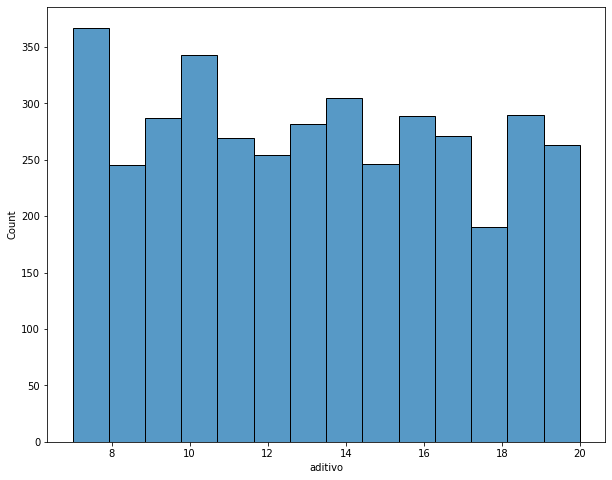

In [29]:
plt.figure()
sns.histplot(df['aditivo'],  bins=len(df['aditivo'].unique()))

<AxesSubplot:xlabel='multiplicativo', ylabel='Count'>

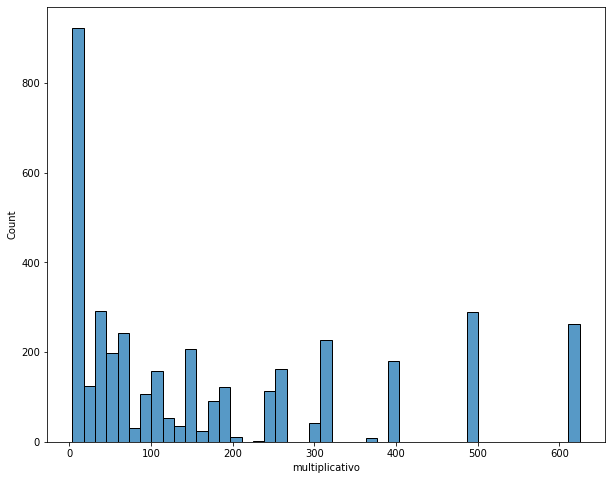

In [30]:
plt.figure()
sns.histplot(df['multiplicativo'], bins=len(df['multiplicativo'].unique()))

### Obtén el número de clases y elementos por clase de cada uno de los scoring anteriores

In [31]:
df.head()

,Cliente,Numero_tickes,Uds_devo,Uds_venta,Eur_venta,Numero_tickes_norm,Uds_devo_norm,Uds_venta_norm,Eur_venta_norm,Numero_tickes_quintil,Uds_devo_quintil,Uds_venta_quintil,Eur_venta_quintil,concat,aditivo,multiplicativo
0,12347,182,0,2458,4310.00,1.425992,-0.688685,1.772114,2.708493,5,4,5,5,5.05.04.05.0,19,500
1,12348,31,0,2341,1797.24,-0.268441,-0.688685,1.724764,0.760126,3,4,5,5,5.03.04.05.0,17,300
2,12349,73,0,631,1757.55,0.541335,-0.688685,0.481880,0.726135,4,4,4,5,4.04.04.05.0,17,320
3,12350,17,0,197,334.40,-0.819070,-0.688685,-0.573395,-0.656387,2,4,2,2,2.02.04.02.0,10,32
4,12352,95,66,536,1545.41,0.794572,1.796968,0.331211,0.541785,4,5,4,4,4.04.05.04.0,17,320


In [32]:
def agregado_clases(df,clase):
    print('Num de clases {}: '.format(clase),len(list(df[clase].unique())))
    print('Elementos por clase {}'.format(clase),round(df[clase].value_counts().mean(),3),'\n')

for i in ['concat','aditivo','multiplicativo']:
    agregado_clases(df,i)

Num de clases concat:  163
Elementos por clase concat 23.933 

Num de clases aditivo:  14
Elementos por clase aditivo 278.643 

Num de clases multiplicativo:  45
Elementos por clase multiplicativo 86.689 



## Scoring probabilístico

Otra opción diferente es, si conocemos las distribuciones de los datos, utilizar esta información para puntuar las diferencias con lo "habitual".


Podemos construir este modelo como la suma de su variable después de la transformación Box-Cox (Yeo-Johnson).

Aplicar el modelo de concatenación para este caso no tiene sentido ya que estaríamos mezclando variables continuas.

In [33]:
df['prob_aditivo'] = df.apply(lambda x: x.Uds_venta_norm + x.Numero_tickes_norm + x.Uds_devo_norm + x.Eur_venta_norm, axis=1)
df['prob_multiplicativo'] = df.apply(lambda x: x.Uds_venta_norm * x.Numero_tickes_norm * x.Uds_devo_norm * x.Eur_venta_norm, axis=1)



In [34]:
df.head()

,Cliente,Numero_tickes,Uds_devo,Uds_venta,Eur_venta,Numero_tickes_norm,Uds_devo_norm,Uds_venta_norm,Eur_venta_norm,Numero_tickes_quintil,Uds_devo_quintil,Uds_venta_quintil,Eur_venta_quintil,concat,aditivo,multiplicativo,prob_aditivo,prob_multiplicativo
0,12347,182,0,2458,4310.00,1.425992,-0.688685,1.772114,2.708493,5,4,5,5,5.05.04.05.0,19,500,5.217914,-4.713648
1,12348,31,0,2341,1797.24,-0.268441,-0.688685,1.724764,0.760126,3,4,5,5,5.03.04.05.0,17,300,1.527764,0.242373
2,12349,73,0,631,1757.55,0.541335,-0.688685,0.481880,0.726135,4,4,4,5,4.04.04.05.0,17,320,1.060665,-0.130450
3,12350,17,0,197,334.40,-0.819070,-0.688685,-0.573395,-0.656387,2,4,2,2,2.02.04.02.0,10,32,-2.737537,0.212303
4,12352,95,66,536,1545.41,0.794572,1.796968,0.331211,0.541785,4,5,4,4,4.04.05.04.0,17,320,3.464536,0.256215


<AxesSubplot:xlabel='prob_aditivo', ylabel='Count'>

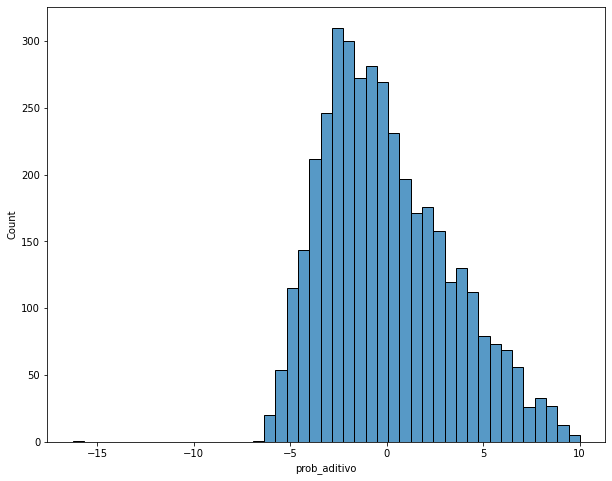

In [35]:
plt.figure()
sns.histplot(df['prob_aditivo'])

<AxesSubplot:xlabel='prob_multiplicativo', ylabel='Count'>

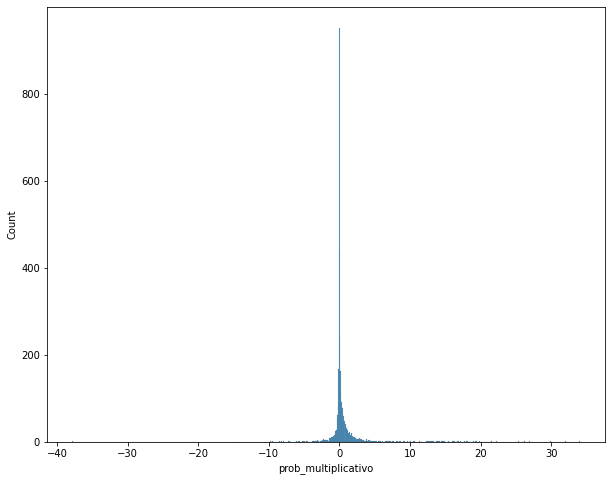

In [36]:
plt.figure()
sns.histplot(df['prob_multiplicativo'])

Vemos que el modelo multplicativo tiene un problema con los ceros, ya que, con tener un 0 en cualquier característica, nos lleva a cero todo el modelo, podemos corregirlo moviendo toda la serie hacia la derecha cinco unidades:

<AxesSubplot:xlabel='prob_multiplicativo', ylabel='Count'>

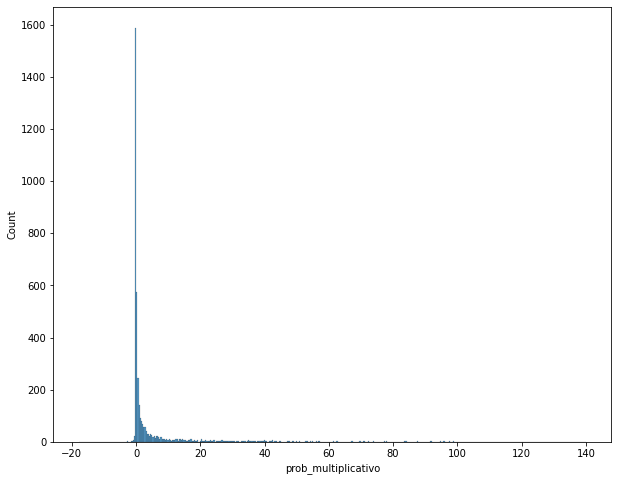

In [37]:
df['prob_multiplicativo'] = df.apply(lambda x: (x.Uds_venta_norm+1) * (x.Numero_tickes_norm+1) * (x.Uds_devo_norm+1) * (x.Eur_venta_norm+1), axis=1)
plt.figure()
sns.histplot(df['prob_multiplicativo'])

Vemos que la forma de los modelos es muy diferente, los modelos proababilísticos ofrecen una distribución más continua y con una mayor tendencia a exagerar los valores que se alejen de la media de forma reiterada.

In [38]:
%pylab
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

cat = df['prob_multiplicativo'].max() - df['prob_multiplicativo'].min()

df['categoria'] = df.apply(lambda x: int((x.prob_multiplicativo / cat)*8), axis=1)

fig = plt.figure()
ax = fig.gca(projection='3d')

plt.show()

k = KMeans()

ax.scatter(df['Numero_tickes_norm'], df['Uds_venta_norm'], df['Eur_venta_norm'], c=df['categoria'])


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\aleex\AppData\Local\Temp/ipykernel_26820/3981486399.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


# Clusterización

La clusterización es la técnica de segmentación que utilizamos cuando queremos descubrir patrones latentes en los datos.

La clusterización comienza haciendo una suposición inicial: podemos agrupar los datos en `k` grupos y, partiendo de esa suposición, va ajustando los `k` grupos tratando de que tengan sentido.


[<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png">](https://scikit-learn.org/stable/modules/clustering.html)

## Ejecución de un algoritmo de clusterización

Para probar el algoritmo de clusterización utilizaremos el juego de datos de venta online que hemos preparado anteriormente, nos quedaremos con el resumen a nivel cliente:



In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import PowerTransformer


plt.rcParams['figure.figsize'] = (10,8)


def obtener_df():
    df = pd.read_csv('./Datos/Ecommerce.csv').drop(columns=['Unnamed: 8'])

    df = df.dropna()
    #df['CustomerID'] = df['CustomerID'].fillna(0)
    #df = df.loc[df['CustomerID'] != 0]
    
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    df['CustomerID'] = df.CustomerID.astype(int)
    df['Total'] = df['Quantity'] * df['UnitPrice']
    df['Cantidad_devo'] = df['Quantity']
    df.loc[df['Cantidad_devo'] > 0, 'Cantidad_devo'] = 0
    df['Cantidad_devo'] = df['Cantidad_devo'] * -1
    df['Cantidad_venta'] = df['Quantity']
    df.loc[df['Cantidad_venta'] < 0, 'Cantidad_venta'] = 0
    
    
    return df

def agregar(df, caracteristica, nivel = 'CustomerID', fn='sum'):
    gb = df.groupby(by=nivel)[caracteristica].agg([fn])
    return gb.reset_index()

def transformar(df, variable):
    p = PowerTransformer(method='yeo-johnson')
    vt = variable + '_norm'
    df[vt] = p.fit_transform(df[[variable]])

def eliminar_outliers(df, variable, criterio):
    p = PowerTransformer(method='yeo-johnson')
    vt = variable + '_t'
    
    ag = agregar(df, variable, fn=criterio)
    ag = ag.loc[ag[criterio] > 0]
    ag[vt] = p.fit_transform(ag[[criterio]])
    outliers = ag[(ag[vt] > 2 ) | (ag[vt] < -2)].CustomerID
    
    df = df[~df['CustomerID'].isin(outliers)].copy()

def obtener_y_preparar():
    df = obtener_df()
    eliminar_outliers(df, 'Cantidad_venta', 'sum')
    eliminar_outliers(df, 'Cantidad_devo', 'sum')
    eliminar_outliers(df, 'InvoiceNo', 'count')
    
    eliminar_outliers(df, 'Total', 'sum')
    
    
    columnas_datos = ['Numero_tickes', 'Uds_devo', 'Uds_venta', 'Eur_venta']
    df = df.groupby(by='CustomerID').agg({'InvoiceNo': 'count', 'Cantidad_devo': 'sum', 'Cantidad_venta': 'sum', 'Total': 'sum'}).reset_index()
    df.columns =  ['Cliente', 'Numero_tickes', 'Uds_devo', 'Uds_venta', 'Eur_venta']

    for x in ['Numero_tickes', 'Uds_devo', 'Uds_venta', 'Eur_venta']:
        transformar(df, x)

    outs = df[(abs(df['Eur_venta_norm']) >2*df['Eur_venta_norm'].mean()+df['Eur_venta_norm'].std())].Cliente
    df = df[~df['Cliente'].isin(outs)].copy()
        
    df.drop(columns=['Numero_tickes', 'Uds_devo', 'Uds_venta', 'Eur_venta', 'Uds_devo_norm'], inplace=True)
    return df

In [40]:
df = obtener_y_preparar()

In [41]:
df

,Cliente,Numero_tickes_norm,Uds_venta_norm,Eur_venta_norm
0,12346,-2.074164,4.156402,-0.399050
1,12347,1.164080,1.313915,0.572500
2,12348,-0.224987,1.276849,0.093868
3,12349,0.439950,0.315841,0.085397
4,12350,-0.678292,-0.481777,-0.265842
...,...,...,...,...
4367,18280,-1.064329,-1.417807,-0.316781
4368,18281,-1.312994,-1.307060,-0.355365
4369,18282,-0.875515,-0.903603,-0.318213
4370,18283,2.312283,0.890338,0.156126


In [42]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.gca(projection='3d')

plt.show()

k = KMeans()
df = obtener_y_preparar()
clses = k.fit_predict(df[['Numero_tickes_norm', 'Uds_venta_norm', 'Eur_venta_norm']])

ax.scatter(df['Numero_tickes_norm'], df['Uds_venta_norm'], df['Eur_venta_norm'], c=clses)


C:\Users\aleex\AppData\Local\Temp/ipykernel_26820/3218183471.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


# Algoritmo KMeans

Para entender mejor qué está pasando cuando clusterizamos, podemos examinar el funcionamiento del algoritmo KMeans que es, posiblemente, el más sencillo de todos los algoritmos de clusterización.

### Inicio 

Este algoritmo comienza escogiendo unos elementos de forma aleatoria de entre todos los que le pasemos.

Estos elementos pasan a ser el centro provisional de los clústers, a este centro se le llama **centroide**; una vez esta selección está hecha, da comienzo el paso iterativo.

### Paso iterativo

El paso iterativo se repite hasta que el algoritmo **converge**

1. Calculamos la distancia desde cada elemento a cada uno de los centroides.
1. Asignamos cada elmento al centroide más próximo
1. Una vez hemos asignado cada elemento a un centroide, calculamos, para cada clúster un nuevo centroide que es la media de todos los elementos del clúster
1. Repetir secuencia hasta que:
   1. Ningún elemento cambia de clúster
   1. Se ha alcanzado el límite de iteraciones configurado

### Fin
Una vez el paso iterativo se rompe quiere decir que los clústers se han estabilizado y los centroides que están seleccionados son los que quedarían seleccionados.

### Problemas de KMeans
* KMeans no garantiza que se encuentre el valor óptimo sino que, debido a que escoge los clústers iniciales de forma aleatoria, sólo nos garantiza un mínimo de entropía (o desorden) local
* Tiene muchas dificultades para encontrar clústers alargados o con formas "raras" (estrella,...)


## Número de clústers

KMeans, como muchos otros algoritmos de clusterización, requiere que le indiquemos cuántos clústers quremos que localice.

Los algoritmos de clusterización, por lo general, no intentarán nunca reducir el número de clústers que deben utilizar por lo que si indicamos números muy altos, simplemente tendremos más desagregación de los datos.

Por ejemplo, si le pedimos 16 o 64 clústers:


In [43]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.gca(projection='3d')

plt.show()

k = KMeans(n_clusters=16)
df = obtener_y_preparar()

clases = k.fit_predict(df[['Numero_tickes_norm', 'Uds_venta_norm', 'Eur_venta_norm']])

ax.scatter(df['Numero_tickes_norm'], df['Uds_venta_norm'], df['Eur_venta_norm'], c=clases)


C:\Users\aleex\AppData\Local\Temp/ipykernel_26820/2981175273.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [44]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.gca(projection='3d')

plt.show()

k = KMeans(n_clusters=64)
df = obtener_y_preparar()

ax.scatter(df['Numero_tickes_norm'], df['Uds_venta_norm'], df['Eur_venta_norm'], c=k.fit_predict(df[['Numero_tickes_norm', 'Uds_venta_norm', 'Eur_venta_norm']]))


C:\Users\aleex\AppData\Local\Temp/ipykernel_26820/3636485888.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [45]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.gca(projection='3d')

plt.show()

k = KMeans(n_clusters=3)
df = obtener_y_preparar()

ax.scatter(df['Numero_tickes_norm'], df['Uds_venta_norm'], df['Eur_venta_norm'], c=k.fit_predict(df[['Numero_tickes_norm', 'Uds_venta_norm', 'Eur_venta_norm']]))


C:\Users\aleex\AppData\Local\Temp/ipykernel_26820/3248645448.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Decidir el número de clústers a mano es una tarea imposible salvo que nuestros datos tengan una estructura muy simple (en cuyo caso no necesitaremos ningún algoritmo).

Para ayudarnos en esa tarea lo que podemos hacer es evaluar el "desorden" interno de cada clúster. 

Este desorden puede calcularse midiendo la distancia entre el centro de cada clúster y sus componentes. 

Por definición es fácil ver que el desorden se reducirá según como aumentamos el número de clústers (habrá más centros y, por lo tanto, cada elemento estará más cerca de un centro).

Cuando tenemos una variable que se va reduciendo según como aumentamos el número de pasos (clústers, tiempo,...) lo que nos interesa es ver cuándo cambia el ritmo de descenso. 

Gráficamente podemos utilizar el método del "codo" para tratar de encontrar el punto en el que pasa esto. Para ello dibujaríamos el valor de ese desorden para diferente número de clústers y nos quedamos con el punto en el que el ritmo de descenso cambia de tendencia.

La librería **Yellowbrick** tiene un visualizador integrado que detecta este punto

In [46]:
from yellowbrick.cluster import KElbowVisualizer
fig = plt.figure()

view = KElbowVisualizer(k, k=(1,12))


view.fit(df[['Numero_tickes_norm', 'Uds_venta_norm', 'Eur_venta_norm']])

view.show()


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

Esta librería también nos da el valor en forma de atributo por si queremos utilizarlo de modo no gráfico.

In [47]:
view.elbow_value_

3

In [48]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

ax = fig.gca(projection='3d')

plt.show()

k = KMeans(n_clusters=view.elbow_value_)
df = obtener_y_preparar()

ax.scatter(df['Numero_tickes_norm'], df['Uds_venta_norm'], df['Eur_venta_norm'], c=k.fit_predict(df[['Numero_tickes_norm', 'Uds_venta_norm', 'Eur_venta_norm']]))


C:\Users\aleex\AppData\Local\Temp/ipykernel_26820/3943513029.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Por supuesto, el método de búsqueda también tiene parámetros que configurar:

In [49]:
from yellowbrick.cluster import KElbowVisualizer
fig = plt.figure()

view = KElbowVisualizer(k, k=(2,25), metric='calinski_harabasz', locate_elbow=True)

view.fit(df[['Numero_tickes_norm', 'Uds_venta_norm', 'Eur_venta_norm']])

view.show()

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

# Distancia

Cuando hablamos de un centro de un clúster y de la distancia entre un elemento y el centro quizás no todos estamos entendiendo lo mismo.

¿Qué es la distancia?

En un algoritmo de clusterización la distancia es una función que, aplicada a dos elementos de nuestra muestra, nos da una medida de su similitud.

Existen muchos tipos de distancias que podemos utilizar y sus diferencias pueden tener grandes repercusiones en los datos:

## Distancia Manhattan

Esta es la distancia más sencilla en la que podemos pensar, se trata únicamente de contar cuántos atributos diferentes tienen dos elementos.

La distancia Manhatan entre 

```
a = [0,1,0,1,0,1]
b = [1,0,1,0,1,0]
```

Será 6, pero también será 6 la distancia Manhattan entre:

```
a = [0,1,0,1,0,1]
b = [1000,1000,1000,1000,-9999999,-9999999]
```

En general utilizaremos la distancia Manhattan únicamente cuando nuestros atributos sean categóricos y no exista un orden ni una magnitud asociada a sus valores.

**Nunca debemos utilizar una distancia Manhattan con variables continuas**, los números con decimales pueden no coincidir aunque sí lo haga su representación visual, si utilizamos la distancia Manhattan con datos continuos lo que pasará es que casi todos los elementos tendrán máxima distancia entre ellos.

## Distancia Euclídea

Forma de medir distancias en el plano, hace la raíz cuadrada de la suma de las diferencias al cuadrado...

$$ DE = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2} $$


## Coef Correlación

Mide la distancia utilizando un coeficiente de correlación entre elmeentos (Pearson, Spearman,..); estos métodos no tienen en cuenta únicamente la distancia numérica entre elementos sino su relación o tendencia.


## SMC

Simple-Matching Coefficient => simplemente mide el número de atributos iguales entre el número de atributos totales, igual que la distancia Manhattan no debemos utilizarlo con variables continuas.

## Funciones de distancia propias

Algunos algoritmos pueden permitir que especifiquemos nuestra propia función de distancia, esto nos permitiría asignar mayor peso a unas variables que a otras.


# K-medoids

K-medoids es un algoritmo casi derivado de KMeans que tiene una diferencia fundamental en su forma de trabajo:

> El centroide es siempre una observación real

En KMeans, cuando calculamos los nuevos centroides lo hacemos como la media entre todas nuestras observaciones, lo cuál puede dar lugar a que escoja un centroide que "caiga" donde no hay puntos, esto es especialmente significativo en conjuntos de datos que pueden tener "huecos":

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from matplotlib.colors import ListedColormap

%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D

datos = np.vstack([np.random.rand(1000), np.random.rand(1000)])

datos[0] = datos[0] - .5
datos[1] = datos[1] - .5


x = np.sqrt(datos[0]**2 + datos[1]**2) 

datos = np.vstack([datos[0], datos[1], x])

df = pd.DataFrame(data=datos.T)
df = df.loc[df[2] > .25]

sns.scatterplot(data=df, x=df[0], y=df[1])

<AxesSubplot:xlabel='0', ylabel='1'>

In [51]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

plt.show()

k = KMeans(n_clusters=1)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=k.fit_predict(df[[0,1]]), palette = 'Accent')

sns.scatterplot(data=None, x=k.cluster_centers_[:,0], y=k.cluster_centers_[:,1], hue=0)


<AxesSubplot:xlabel='0', ylabel='1'>

In [52]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

plt.show()

k = KMeans(n_clusters=3)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=k.fit_predict(df[[0,1]]), palette = 'Accent')

sns.scatterplot(data=None, x=k.cluster_centers_[:,0], y=k.cluster_centers_[:,1], hue=0)


<AxesSubplot:xlabel='0', ylabel='1'>

Si añadimos algunos outliers:

In [53]:
plt.figure()
xx = np.random.rand(1000)
xx = np.hstack([xx, np.random.rand(50) + 1])

xx -= .5

yy = np.random.rand(1000)
yy = np.hstack([yy, np.random.rand(50) + 1])
yy -= .5

x = np.sqrt(xx**2 + yy**2) 

datos = np.vstack([xx, yy, x])
    
df = pd.DataFrame(data=datos.T)    
df = df.loc[df[2] > .25]
sns.scatterplot(data=df, x=df[0], y=df[1])

<AxesSubplot:xlabel='0', ylabel='1'>

In [54]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

plt.show()

k = KMeans(n_clusters=3)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=k.fit_predict(df[[0,1]]), palette = 'Accent')

sns.scatterplot(data=None, x=k.cluster_centers_[:,0], y=k.cluster_centers_[:,1], hue=0)

<AxesSubplot:xlabel='0', ylabel='1'>

In [55]:
plt.figure()
xx = np.random.rand(1000)
xx = np.hstack([xx, np.random.rand(50) + 2])

xx -= .5

yy = np.random.rand(1000)
yy = np.hstack([yy, np.random.rand(50) + 2])
yy -= .5

x = np.sqrt(xx**2 + yy**2) 
datos = np.vstack([xx, yy, x])
    
df = pd.DataFrame(data=datos.T)    
df = df.loc[df[2] > .25]
sns.scatterplot(data=df, x=df[0], y=df[1])

<AxesSubplot:xlabel='0', ylabel='1'>

In [56]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

plt.show()

k = KMeans(n_clusters=3)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=k.fit_predict(df[[0,1]]), palette = 'Accent')

sns.scatterplot(data=None, x=k.cluster_centers_[:,0], y=k.cluster_centers_[:,1], hue=0)

<AxesSubplot:xlabel='0', ylabel='1'>

In [57]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

plt.show()

k = KMeans(n_clusters=2)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=k.fit_predict(df[[0,1]]), palette = 'Accent')

sns.scatterplot(data=None, x=k.cluster_centers_[:,0], y=k.cluster_centers_[:,1], hue=0)

<AxesSubplot:xlabel='0', ylabel='1'>

Con K-Medoids

In [58]:
from sklearn_extra.cluster import KMedoids

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

plt.show()

k = KMedoids(n_clusters=2)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=k.fit_predict(df[[0,1]]), palette = 'Accent')

sns.scatterplot(data=None, x=k.cluster_centers_[:,0], y=k.cluster_centers_[:,1], hue=0)

<AxesSubplot:xlabel='0', ylabel='1'>

## Clusters jerárquicos

Los clústers jerárquicos son el equivalente a los árboles de decisión para la clusterización, estos árboles van tomando decisiones maximizando la separación entre las ramas por las que van avanzando.

No es necesario indicar el máximo número de ramas ya que, cuando se ha generado el árbol, podemos "podarlo" a la altura que deseemos.

Por defecto el propio algoritmo tratará de minimizar el número de clústers salvo que le digamos lo contrario:

In [59]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from matplotlib.colors import ListedColormap

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

datos = np.vstack([np.random.rand(1000), np.random.rand(1000)])

datos[0] = datos[0] - .5
datos[1] = datos[1] - .5


x = np.sqrt(datos[0]**2 + datos[1]**2) 

datos = np.vstack([datos[0], datos[1], x])

df = pd.DataFrame(data=datos.T)
df = df.loc[df[2] > .25]


ac = AgglomerativeClustering()


ac.fit(df[[0,1]])

sns.scatterplot(data=df, x=df[0], y=df[1], hue=ac.fit_predict(df[[0,1]]), palette = 'Accent')


<AxesSubplot:xlabel='0', ylabel='1'>

In [60]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from matplotlib.colors import ListedColormap

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

datos = np.vstack([np.random.rand(1000), np.random.rand(1000)])

datos[0] = datos[0] - .5
datos[1] = datos[1] - .5


x = np.sqrt(datos[0]**2 + datos[1]**2) 

datos = np.vstack([datos[0], datos[1], x])

df = pd.DataFrame(data=datos.T)
df = df.loc[df[2] > .25]


ac = AgglomerativeClustering(n_clusters=4)


ac.fit(df[[0,1]])

sns.scatterplot(data=df, x=df[0], y=df[1], hue=ac.fit_predict(df[[0,1]]), palette = 'Accent')


<AxesSubplot:xlabel='0', ylabel='1'>

También podemos utilizar Yellowbrick para determinar el número de clústers más adecuado:

In [61]:
from yellowbrick.cluster import KElbowVisualizer
plt.figure()

vis = KElbowVisualizer(ac, k=(2,20))

vis.fit(df[[0,1]])

vis.show()


<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from matplotlib.colors import ListedColormap

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

datos = np.vstack([np.random.rand(1000), np.random.rand(1000)])

datos[0] = datos[0] - .5
datos[1] = datos[1] - .5


x = np.sqrt(datos[0]**2 + datos[1]**2) 

datos = np.vstack([datos[0], datos[1], x])

df = pd.DataFrame(data=datos.T)
df = df.loc[df[2] > .25]


ac = AgglomerativeClustering(n_clusters=5)


ac.fit(df[[0,1]])

sns.scatterplot(data=df, x=df[0], y=df[1], hue=ac.fit_predict(df[[0,1]]), palette = 'Accent')

<AxesSubplot:xlabel='0', ylabel='1'>

# DBSCAN

La clusterización DBScan representa una evolución en la forma de buscar clústers ya que trata de seguir el patrón que haríamos las personas, considerando puntos contiguos como relacionados y los saltos entre bloques como nuevos clusters.

Si partimos de un conjunto de datos que esté "roto" ninguno de los algoritmos que hemos visto hasta ahora tendrá garantizado un buen resultado:

In [63]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from matplotlib.colors import ListedColormap

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

xx = np.random.rand(1000)
xx = np.hstack([xx, np.random.rand(50) + 1])

xx -= .5

yy = np.random.rand(1000)
yy = np.hstack([yy, np.random.rand(50) + 1])
yy -= .5

x = np.sqrt(xx**2 + yy**2) 

datos = np.vstack([xx, yy, x])
    
df = pd.DataFrame(data=datos.T)    
df = df.loc[(df[2] > .35) | (df[2] < .15)]

In [64]:

plt.figure()

k = KMeans(n_clusters=5)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=ac.fit_predict(df[[0,1]]), palette = 'Accent')

<AxesSubplot:xlabel='0', ylabel='1'>

In [65]:
plt.figure()

ac = AgglomerativeClustering(n_clusters=5)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=ac.fit_predict(df[[0,1]]), palette = 'Accent')

<AxesSubplot:xlabel='0', ylabel='1'>

DBSCAN es capaz de, con muy pocos parámetros, darnos el resultado buscado:

* eps: distancia mínima que consideramos antes de dar un salto de clúster
* min_samples: indica el mínimo número de observaciones que pedimos antes de crear un nuevo clúster.

In [66]:

from sklearn.cluster import DBSCAN

plt.figure()

db = DBSCAN(
       eps=.1,
       min_samples=10)

sns.scatterplot(data=df, x=df[0], y=df[1], hue=db.fit_predict(df[[0,1]]), palette = 'Accent')

<AxesSubplot:xlabel='0', ylabel='1'>

Las ventajas de DBSCAN son:
* Puede evitar outliers mediante el número mínimo de observaciones que pedimos en cada clúster
* Es capaz de detectar formas muy complejas
* No nos exige establecer un número de clústers inicial

Desventajas:
* Es difícil dar con un buen parámetro de epsilon
* Los puntos en los bordes pueden confundirse

In [67]:
import numpy as np
from numpy import pi
# import matplotlib.pyplot as plt

N = 1000
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)


res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

plt.figure()
sns.scatterplot(data=x_a, x=x_a[:,0], y=x_a[:,1], hue=1)
sns.scatterplot(data=x_b, x=x_b[:,0], y=x_b[:,1], hue=1)


xx = np.random.rand(1000)*12
#xx = np.hstack([xx, np.random.rand(50) + 1])

xx -= 6

yy = np.random.rand(1000)*12
#yy = np.hstack([yy, np.random.rand(50) + 1])
yy -= 6

x = np.sqrt(xx**2 + yy**2) 

datos = np.vstack([xx, yy, x])
    
df = pd.DataFrame(data=datos.T)    
df = df.loc[(df[2] <2)]


sns.scatterplot(data=df, x=df[0], y=df[1])

<AxesSubplot:xlabel='0', ylabel='1'>

In [68]:
import numpy as np
from numpy import pi
# import matplotlib.pyplot as plt

N = 1000
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 3*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -3*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

plt.figure()

xx = np.random.rand(2000)*12
xx -= 6

yy = np.random.rand(2000)*12
yy -= 6

temp = np.vstack([xx, yy, np.sqrt(xx**2 + yy**2)])
temp = temp[:,temp[2] < 2]
temp = np.array([x for x in zip(temp[0], temp[1])])
temp = np.concatenate([temp, x_a, x_b])

df = pd.DataFrame(data=temp)

sns.scatterplot(data=df, x=df[0], y=df[1])

<AxesSubplot:xlabel='0', ylabel='1'>

In [69]:
import sklearn.metrics


plt.figure()

db = DBSCAN(
       eps=1.5,
       min_samples=10
        )

sns.scatterplot(data=df, x=df[0], y=df[1], hue=db.fit_predict(df[[0,1]]), palette = 'Accent')

<AxesSubplot:xlabel='0', ylabel='1'>

# Por qué clusterizamos

Hemos visto que clusterizar no tiene por qué ser tan sencillo como clasificar, partimos de la nada y hay múltiples direcciones en las que podemos movernos, es, por lo tanto, más importante que nunca, no perder el foco de a dónde queremos llegar.

## Clusterizamos para simplificar

El objetivo de clusterizar debe ser simplificar nuestros datos y, por lo tanto, facilitar la comunicación. Una expectativa mínima de la clusterización debería ser adquirir un nuevo vocabulario que nos permita referirnos a nuestros clientes, productos, proveedores,... de una forma agregada que tenga **sentido de negocio**

### ¿Cómo se pasa de estas visualizaciones y clústers a un conocimiento de negocio?

Lo primero que hay que tener en cuenta es que, las visualizaciones de los clústers solo tienen sentido mientras vemos el clúster al entender qué hace cada algoritmo.

Nosotros hemos representado clústers de 2 y 3 dimenesiones pero, en la realidad, lo normal es que nuestros datos tengan docenas de atributos y esos clústers no pueden visualizarse; si tratamos de pasarlos a 2 o 3 dimensiones es muy posible que el conjunto de atributos que escojamos no contenga la combinación adecuada que les de **sentido visual**, pero eso no quiere decir que no tenga sentido a nivel negocio.

¿Cómo podemos extraer una información de negocio de los clústers?

Hemos visto que hay formas para determinar el número de clústers adecuado desde una perspectiva matemática, nosotros, como analistas de negocio lo que debemos hacer es encontrar el número adecuado desde una perspectiva de negocio, para ello, lo que debemos hacer es sacar las características de cada clúster, estudiar qué los hace diferentes.

Quizás el clúster A está formado por clientes que se registraron hace menos de un año, hacen más de dos pedidos al mes y tienen un 50% o más de gasto en la sección X... ¿tendría esto sentido de negocio? podemos encontrar algo que nos ayude a determinar qué es importante y qué no.

## Profecías autocumplidas / imposibles

A la hora de generar clústers es importante encontrar un equilibrio adecuado entre proporcionar datos al algoritmo para que pueda llegar a conclusiones interesantes (recordemos que es un proceso de descubrimiento de información) y tratar de que las conclusiones a las que llega puedan ser interpretadas.

En ese sentido es conveniente evitar introducir atributos como:
 - Temperatura en el exterior en el momento de hacer la compra
 - Grados de latitud por encima del paralelo 47
 - ...
 
Pero, de la misma forma que evitaremos integrar información que sólo nos añada ruido al análisis, también debemos evitar caer en la tentación de ser nosotros los que deciden qué atributos vamos a proporcionar al algoritmo para que la respuesta vaya en la línea que nos gustaría.

Es habitual, para clusterizar, repetir el proceso hasta que nos agrupe los datos como nosotros queremos y no como el algoritmo entiende, para ello acabamos eliminando o añadiendo atributos hasta que no queda otro remedio que la creación de unos clusters adaptados a nuestra necesidad.

Este uso del algoritmo de clusterización para que consiga cumplir una hipótesis inicial resta potencia a su ejecución ya que no le damos importancia a la parte de descubrimiento de patrones sino que nos centramos en un objetivo casi de clasificación.

Por otro lado, es cierto que los algoritmos de clusterización raramente nos proporcionan un patrón claro al que podamos ponerle nombre (recordad la importancia de generar vocabulario de negocio en la sesión de clasificación) pero, mediante un uso iterativo de clusterización - evaluación, se puede llegar a identificar algunas realidades de nuestro negocio que quizás no conocíamos.

Tal vez, de los clústers generados por un algoritmo de clusterización sólo uno de ellos tenga sentido de negocio pero, si lo tiene, podemos utilizarlo incluso aunque el resto tenga que ser descartado.


## Clusterización - Clasificación

Los algoritmos de segmentación pueden utilizarse de forma conjunta, quizás queremos hacer un primer paso de clusterización basado en distancias para organizar nuestros datos por similitud.

A continuación, evaluando los clústers, vemos que alguno de ellos puede ser representativo de una realidad latente en el negocio. 

Escogemos este clúster y etiquetamos los datos como "pertenecientes a ese clúster" y "no pertenecientes a este clúster" y le pedimos a un algoritmo de clasificación que obtenga las reglas que caractericen el grupo.

De esta forma obtendremos un conjunto de reglas no basadas en distancias que nos permitan entender mejor lo que "mueve" a ese grupo que hemos detectado.

# Casos de uso 

## Scoring
* Queremos encontrar una clasificación con capacidad para integrar las reglas del negocio
* Debemos poder utilizar esa clasificación como herramienta de comunicación con tomadores de decisiones

## KMeans
* Nuestros datos están normalizados y no contienen outliers
* Podemos estimar el número de clusters necesarios o utilizar el método del codo
* Los atributos de nuestras observaciones son "equiparables"
* **Nuestros datos no tienen outliers**

## KMedoids
* Estamos en el caso de uso de de KMeans pero tenemos outliers

## Clústers Jerárquicos
* Número de clústers y observaciones muy alto, el clúster jerárquico toma decisiones como un árbol de decisión.

## DBSCAN
* Creamos clusters desde una perspectiva de "continuidad" en los datos

